# Exploratory Data Analysis & Cleaning

did le-son use review and description together for topic modelling?  

### loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer, PowerTransformer

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 110)

lapath = 'data/losangeles-13feb/listings (1).csv'
pathname = 'data/sf-12feb/listings (1).csv'
nypath = 'data/newyork-12feb/listings (1).csv'

df = pd.read_csv(pathname)
print('sf', df.shape)
df.info()


sf (8587, 106)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8587 entries, 0 to 8586
Columns: 106 entries, id to reviews_per_month
dtypes: float64(20), int64(23), object(63)
memory usage: 6.9+ MB


/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#we drop columns that don't have bearing on the customer
neededcolumns = ['id', 'listing_url', 'name', 'summary', 'space', 'description',
                 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
                 'host_id', 'host_url', 'host_since', 'host_about', 'host_response_time', 
                 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
                'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 
                'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 
                'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price',
                'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
                'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_rating',
                'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture',
                'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']

df = df[neededcolumns]

In [3]:
import pandas_profiling
#uncomment rows below if running for the first time

# report = pandas_profiling.ProfileReport(df, html = {'style': {'full_width': True}})
# report.to_file('data_summary.html')
# report

### Data Cleaning

#### Cleaning data formats

In [4]:
#cleaning dollar formats
#this does not deal with null values (due to try except function)
#null values addressed later

import re

def dollarformat(x):
    '''
    convert currency strings into interger amounts
    removes $ , and . 
    converts str into int
    '''
    try: 
        return round(int(re.sub('[$,,,.]', '', x))/100,1)
    except:
        return x

df['cleaning_fee'] = df['cleaning_fee'].map(lambda x: dollarformat(x))
df['security_deposit'] = df['security_deposit'].map(lambda x: dollarformat(x))

df['extra_people'] = df['extra_people'].map(lambda x: dollarformat(x))

df['price'] = df['price'].map(lambda x: dollarformat(x))
df['weekly_price'] = df['weekly_price'].map(lambda x: dollarformat(x))

In [5]:
def responsetime(x):
    if x == 'a few days or more':
        return int(1)
    elif x == 'within a day':
        return int(2)
    elif x == 'within a few hours':
        return int(3)
    elif x == 'within an hour':
        return int(4)
    else:
        return x
    
df.host_response_time = df.host_response_time.map(lambda x : responsetime(x))

In [6]:
def percentage(x):
    '''
    convert % strings into interger amounts
    removes % , and . 
    converts str into int
    '''
    try: 
        return round(int(re.sub('[%,,,.]', '', x))/100,2)
    except:
        return x

df.host_acceptance_rate = df.host_acceptance_rate.map(lambda x: percentage(x))
df.host_response_rate = df.host_response_rate.map(lambda x: percentage(x))


In [7]:
#converting strings to date time
df.first_review = pd.to_datetime(df.first_review)
df.host_since = pd.to_datetime(df.host_since)
df.last_review = pd.to_datetime(df.last_review)

df['listing_age'] = pd.datetime.today() - df.first_review
df['listing_age'] = round(df['listing_age'] / np.timedelta64(1, 'D'), 0)

df['host_age'] = pd.datetime.today() - df.host_since
df['host_age'] = round(df['host_age'] / np.timedelta64(1, 'D'), 0)

In [8]:
def truefalse(x):
    if x == 't':
        return 1
    if x == 'f':
        return 0
    else:
        return x

df.host_is_superhost = df.host_is_superhost.map(lambda x : truefalse(x))
df.instant_bookable = df.instant_bookable.map(lambda x : truefalse(x))
df.host_identity_verified = df.host_identity_verified.map(lambda x : truefalse(x))
df.require_guest_profile_picture = df.require_guest_profile_picture.map(lambda x : truefalse(x))

/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.191e+03, 7.230e+02, 4.903e+03, 5.090e+02, 4.500e+01, 9.950e+02,
        2.100e+01, 1.300e+02, 4.000e+00, 5.700e+01]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

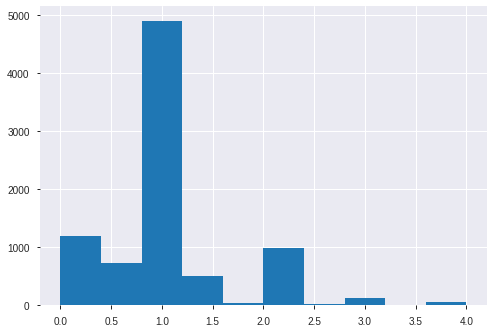

In [9]:
def bedbath(x):
    if x > 4:
        return 4
    else:
        return x

df['bedbathratio'] = df.bedrooms / df.bathrooms 
df['bedbathratio'] = df['bedbathratio'].map(lambda x: bedbath(x))

df['intercept'] = 1

plt.hist(df.bedbathratio)

In [10]:
def cancels(x):
    if x == 'super_strict_60':
        return int(1)
    elif x == 'super_strict_30':
        return int(2)
    elif x == 'strict':
        #Full refund for cancellations made within 48 hours of booking, 
        #if the check-in date is at least 14 days away. 
        #50% refund for cancellations made at least 7 days before check-in. 
        #No refunds for cancellations made within 7 days of check-in
        return int(3)
    elif x == 'strict_14_with_grace_period':
        return int(4)
    elif x == 'luxury_moderate':
        return int(5)
    elif x == 'moderate':
        return int(5)
    elif x == 'flexible':
        #full refund 1 day before arrival
        return int(6)
    else:
        return x
#nag it what's the diff between luxury moderate
    
df.cancellation_policy = df.cancellation_policy.map(lambda x: cancels(x))

def bedtype(x):
    if x == 'Real Bed':
        return 1
    else:
        return 0
df.bed_type = df.bed_type.map(lambda x: bedtype(x))


#### adding dummy variables

In [11]:
def room(x):
    if x == 'Entire home/apt':
        return 4
    elif x == 'Private room':
        return 3
    elif x  == 'Hotel room':
        return 2
    elif x == 'Shared room':
        return 1
    else:
        return x
df.room_type = df.room_type.map(lambda x: room(x))

df = df.merge(pd.get_dummies(df.room_type, prefix = 'room'), left_index = True, right_index = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8587 entries, 0 to 8586
Data columns (total 64 columns):
id                                  8587 non-null int64
listing_url                         8587 non-null object
name                                8587 non-null object
summary                             8367 non-null object
space                               7290 non-null object
description                         8533 non-null object
neighborhood_overview               6328 non-null object
notes                               5163 non-null object
transit                             5878 non-null object
access                              5199 non-null object
interaction                         5752 non-null object
house_rules                         6217 non-null object
host_id                             8587 non-null int64
host_url                            8587 non-null object
host_since                          8587 non-null datetime64[ns]
host_about                      

In [13]:
import re

df.amenities = df.amenities.apply(
    lambda x: re.sub('[^a-zA-Z,\/\s\d-]*', '', x).split(sep=','))

In [14]:
#do context specific amenities engineering
#breakfast, host greets you, netflix, family/kid friendly, coffee maker, tv, cable tv
#free parking on premises, free street parking
#alot of these are useless - you don't care about them

#changeable amenities
df['breakfast'] = df.amenities.map(lambda listing_amenities: 'Breakfast' in listing_amenities)
df['breakfast'] = df['breakfast'].astype(int)
df['family_friendly'] = df.amenities.map(lambda listing_amenities: 'Family/kid friendly' in listing_amenities)
df['family_friendly'] = df['family_friendly'].astype(int)
df['coffee_maker'] = df.amenities.map(lambda listing_amenities: 'Coffee maker' in listing_amenities)
df['coffee_maker'] = df['coffee_maker'].astype(int)
df['netflix'] = df.amenities.map(lambda listing_amenities: 'Netflix' in listing_amenities)
df['netflix'] = df['netflix'].astype(int)
df['greeting'] = df.amenities.map(lambda listing_amenities: 'Host greets you' in listing_amenities)
df['greeting'] = df['greeting'].astype(int)

#'unchangable' amenities
df['parkingone'] = df.amenities.map(lambda listing_amenities: 'Free parking on premises' in listing_amenities)
df['parkingtwo'] = df.amenities.map(lambda listing_amenities: 'Free street parking' in listing_amenities)
df['freeparking'] = df.parkingone + df.parkingtwo
df['freeparking'] = df['freeparking'].astype(int)
df.drop(labels = ['parkingone', 'parkingtwo'], axis = 1, inplace = True)
df['outdoorpart'] = df.amenities.map(lambda listing_amenities: 'Patio or balcony' in listing_amenities)
df['outdoorpart'] = df['outdoorpart'].astype(int)


/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [15]:
df.property_type.replace('Treehouse','Bungalow',inplace=True)
df.property_type.replace('Cabin','Bungalow',inplace=True)
df.property_type.replace('Dome house','Bungalow',inplace=True)
df.property_type.replace('Earth house','Bungalow',inplace=True)
df.property_type.replace('Hut','Bungalow',inplace=True)
df.property_type.replace('Yurt','Bungalow',inplace=True)
df.property_type.replace('Tiny house','Bungalow',inplace=True)


# Boutique hotel, resort most like a hotel
df.property_type.replace('Boutique hotel','Hotel',inplace=True)
df.property_type.replace('Resort','Hotel',inplace=True)
df.property_type.replace('Aparthotel','Hotel',inplace=True)

# Farm stay to Bed and breakfast
df.property_type.replace('Farm stay','Bed and breakfast',inplace=True)

# Castle, Yurt, Tent, Hostel and Chalet to other
df.property_type.replace('Minsu (Taiwan)','Other',inplace=True)
df.property_type.replace('Vacation home','Other',inplace=True)
df.property_type.replace('Cave','Other',inplace=True)
df.property_type.replace('Igloo','Other',inplace=True)
df.property_type.replace('Pension (South Korea)','Other',inplace=True)
df.property_type.replace('Train','Other',inplace=True)
df.property_type.replace('Houseboat','Other',inplace=True)
df.property_type.replace('Bus','Other',inplace=True)
df.property_type.replace('Island','Other',inplace=True)
df.property_type.replace('Casa particular (Cuba)','Other',inplace=True)
df.property_type.replace('Dome','Other',inplace=True)
df.property_type.replace('Tipi','Other',inplace=True)
df.property_type.replace('Barn','Other',inplace=True)
df.property_type.replace('Campsite','Other',inplace=True)
df.property_type.replace('Castle','Other',inplace=True)
df.property_type.replace('Chalet','Other',inplace=True)
df.property_type.replace('Tent','Other',inplace=True)
df.property_type.replace('Farm stay','Other',inplace=True)
df.property_type.replace('Boat','Other',inplace=True)
df.property_type.replace('Dorm','Other',inplace=True)

df.property_type.value_counts()

df = df.merge(pd.get_dummies(df.property_type, prefix = 'prop'), right_index = True, left_index = True)



In [16]:
df = df.merge(pd.get_dummies(df.neighbourhood_cleansed, prefix = 'neighbourhood'), left_index = True, right_index = True)

#### dealing with nulls


In [18]:
print('% missing values for host response rate col', round(len(df[df.host_response_rate.isnull() == True])/len(df),2))
x = df.host_response_rate.mean()
df.host_response_rate.fillna(value = x, inplace = True)

% missing values for host response rate col 0.14


In [19]:
print('% missing values for security deposit col', round(len(df[df.security_deposit.isnull() == True])/len(df),2))
x = df.security_deposit.mode()
df.security_deposit.fillna(value = x, inplace = True)

% missing values for security deposit col 0.2


In [20]:
print('% missing values for cleaning fee col', round(len(df[df.cleaning_fee.isnull() == True])/len(df),2))
x = df.cleaning_fee.median()
x
df.cleaning_fee.fillna(value = x, inplace = True)


% missing values for cleaning fee col 0.11


In [21]:
print('% missing values for review scores col', round(len(df[df.review_scores_rating.isnull() == True])/len(df),2))

def ratings(x):
    if x >= 4.91 * 20:
        #perfection
        return '>4.9'
    elif x >= 4.8  * 20:
        #exceptional
        return '>4.8'
    elif x >= 4.6 * 20:
        #good
        return '>4.6'
    elif x >= 4.2 * 20:
        #within expectations
        return '>4.2'
    elif x >= 4.0 * 20:
        #fair
        return '>4.0'
    elif x < 4 * 20:
        #below expectations
        return '<4.0' 

df['adjusted_scores'] = df.review_scores_rating.map(lambda x: ratings(x))

df['adjusted_scores'].fillna(value = 'no review', inplace = True)

df = df.merge(pd.get_dummies(df.adjusted_scores, prefix = 'review_of'), left_index = True, right_index = True)


% missing values for review scores col 0.24


(array([ 523.,  762., 1424., 3128., 1501.,  709.,  356.,  139.,   39.,
           6.]),
 array([-2.25271431, -1.60886479, -0.96501528, -0.32116576,  0.32268375,
         0.96653327,  1.61038278,  2.2542323 ,  2.89808182,  3.54193133,
         4.18578085]),
 <a list of 10 Patch objects>)

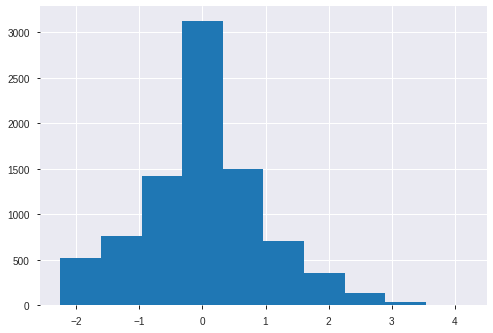

In [22]:
pty = PowerTransformer(method = 'yeo-johnson')

plt.hist(pty.fit_transform(df['cleaning_fee'].values.reshape(-1,1)))

#### dealing with outliers

In [23]:
# def outliers(df, column, num_dev=4):
    
#     q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
#     iqr = q75 - q25
    
#     max_ = q75 + num_dev * iqr
#     # identify the points
#     outlier_mask = [True if x > max_ else False for x in df[column]]
#     print('{} outliers found out of {} data points, {}% of the data. {} is the max'.format(
#         sum(outlier_mask), len(df[column]),
#         100 * (sum(outlier_mask) / len(df[column])),max_))
#     return outlier_mask

In [24]:
# df['outliers'] = outliers(df, 'bathrooms')
# df = df[df['outliers'] == False]
# df.shape

In [25]:
# df['outliers'] = outliers(df, 'cleaning_fee')
# df = df[df['outliers'] == False]
# df.shape

In [26]:
# df['outliers'] = outliers(df, 'security_deposit')
# df = df[df['outliers'] == False]
# df.shape

In [27]:
# df['outliers'] = outliers(df, 'beds', num_dev = 5)
# df = df[df['outliers'] == False]
# df.shape

# df.drop(labels = 'outliers', inplace = True, axis = 1)

#### feature engineering

In [28]:
df.shape

(8587, 133)

In [29]:
import pickle

with open('dataframe', 'wb') as file:
    df = pickle.dump(df, file)